# Exercises

In [2]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [9]:
# Load the data from the provided file
with open('data/linear_track_data.pickle', 'rb') as f:
    data = pickle.load(f)
x = data['x']
t = data['t']
spikes = data['spikes']

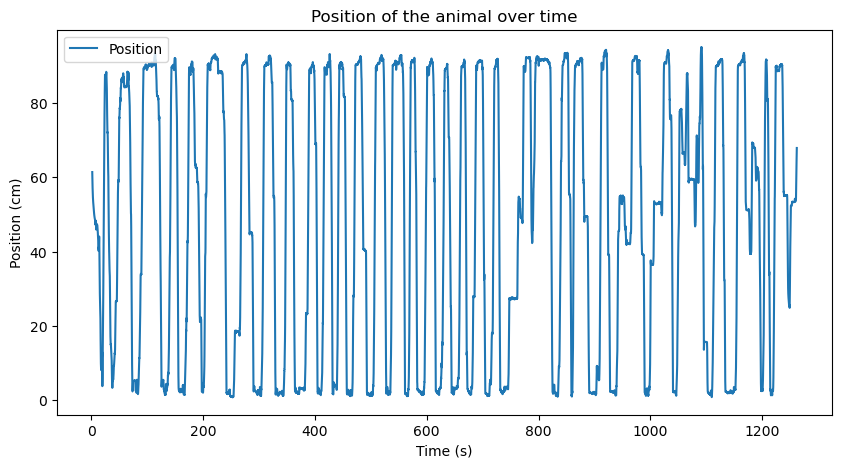

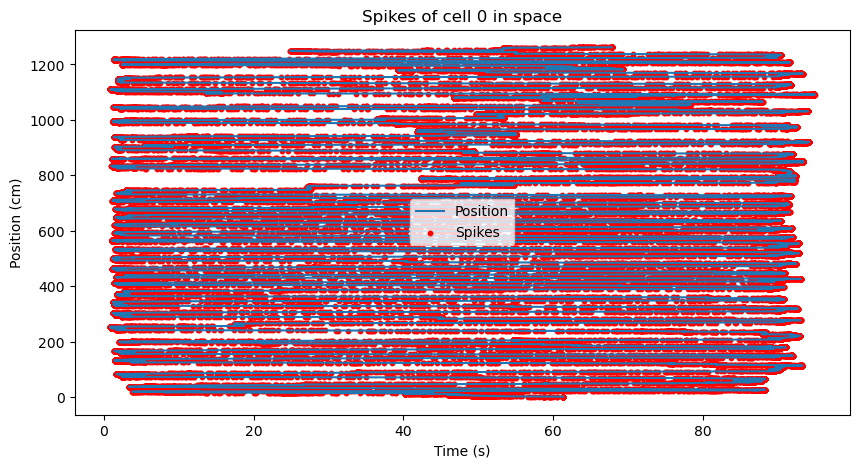

In [10]:
# Plot the position of the animal over time
plt.figure(figsize=(10, 5))
plt.plot(t, x, label='Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
plt.title('Position of the animal over time')
plt.legend()
plt.show()

# Select a cell (e.g., cell 0) and plot its spikes in space
selected_cell = 0
spike_times = spikes[selected_cell]
spike_positions = np.interp(spike_times, t, x)

plt.figure(figsize=(10, 5))
plt.plot(x, t, label='Position')
plt.scatter(spike_positions, spike_times, color='red', label='Spikes', s=10)
plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
plt.title(f'Spikes of cell {selected_cell} in space')
plt.legend()
plt.show()


C:\Users\sabah\AppData\Local\Temp\ipykernel_14948\2958645412.py:11: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts / occupancy


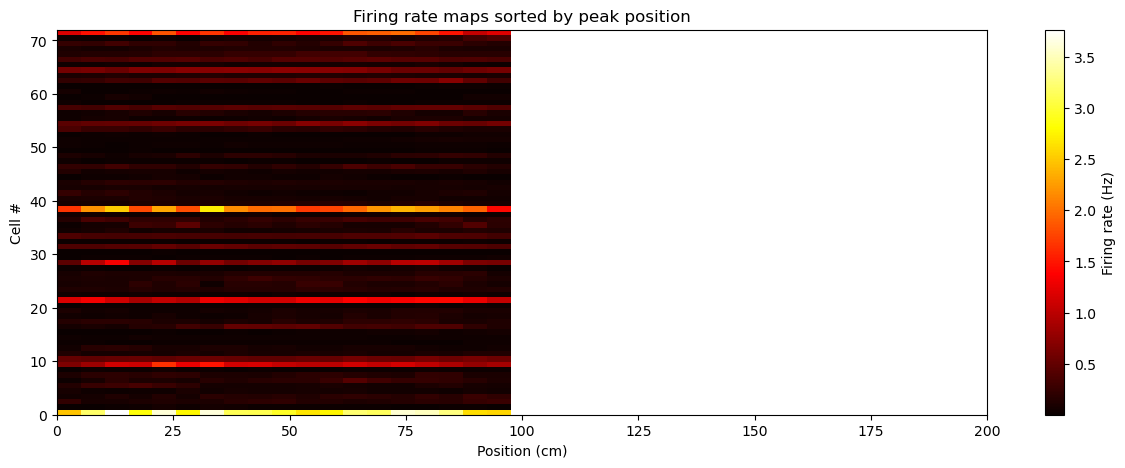

In [11]:
space_bins = np.arange(0., 200., 5.)

# Compute the firing rate maps
firing_rate_maps = []
for cell_spikes in spikes:
    spike_positions = np.interp(cell_spikes, t, x)
    spike_counts, _ = np.histogram(spike_positions, bins=space_bins)
    occupancy, _ = np.histogram(x, bins=space_bins)
    firing_rate = spike_counts / occupancy
    firing_rate_maps.append(firing_rate)

firing_rate_maps = np.array(firing_rate_maps)

# Plot firing rate maps sorted by peak position
peak_positions = np.argmax(firing_rate_maps, axis=1)
sorted_indices = np.argsort(peak_positions)
sorted_firing_rate_maps = firing_rate_maps[sorted_indices]

plt.figure(figsize=(15, 5))
plt.imshow(sorted_firing_rate_maps, aspect='auto', cmap='hot', extent=[0, 200, 0, len(spikes)])
plt.xlabel('Position (cm)')
plt.ylabel('Cell #')
plt.title('Firing rate maps sorted by peak position')
plt.colorbar(label='Firing rate (Hz)')
plt.show()


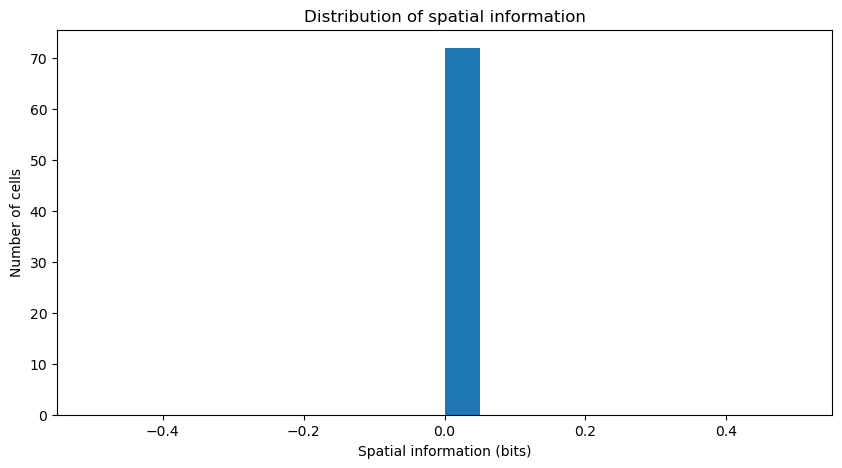

In [12]:
def spatial_information(firing_rate, occupancy):
    p_x = occupancy / np.sum(occupancy)
    mean_firing_rate = np.mean(firing_rate)
    info = np.nansum(p_x * (firing_rate / mean_firing_rate) * np.log2(firing_rate / mean_firing_rate))
    return info

occupancy, _ = np.histogram(x, bins=space_bins)
occupancy = occupancy / np.sum(occupancy)  # Normalize occupancy
spatial_info = [spatial_information(fr, occupancy) for fr in firing_rate_maps]

# Plot the spatial information distribution
plt.figure(figsize=(10, 5))
plt.hist(spatial_info, bins=20)
plt.xlabel('Spatial information (bits)')
plt.ylabel('Number of cells')
plt.title('Distribution of spatial information')
plt.show()


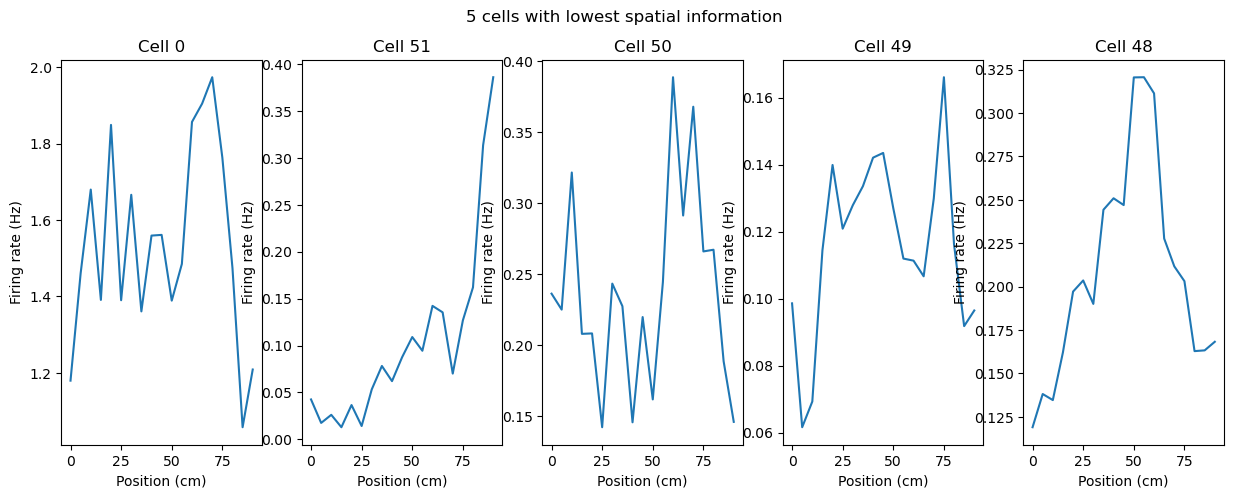

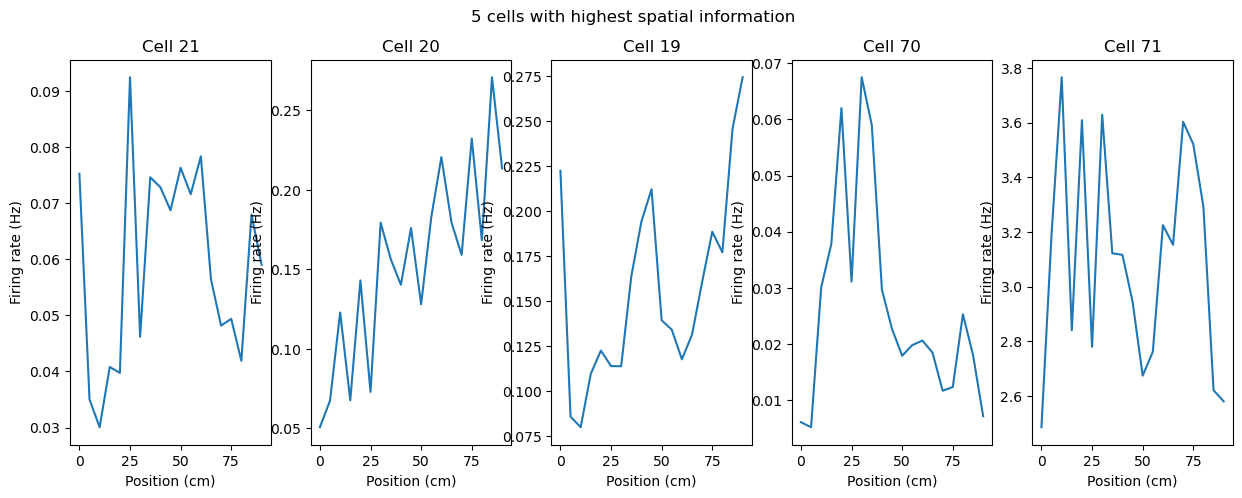

In [13]:
lowest_info_indices = np.argsort(spatial_info)[:5]
highest_info_indices = np.argsort(spatial_info)[-5:]

# Plot lowest spatial information cells
plt.figure(figsize=(15, 5))
for i, idx in enumerate(lowest_info_indices):
    plt.subplot(1, 5, i+1)
    plt.plot(space_bins[:-1], firing_rate_maps[idx])
    plt.title(f'Cell {idx}')
    plt.xlabel('Position (cm)')
    plt.ylabel('Firing rate (Hz)')
plt.suptitle('5 cells with lowest spatial information')
plt.show()

# Plot highest spatial information cells
plt.figure(figsize=(15, 5))
for i, idx in enumerate(highest_info_indices):
    plt.subplot(1, 5, i+1)
    plt.plot(space_bins[:-1], firing_rate_maps[idx])
    plt.title(f'Cell {idx}')
    plt.xlabel('Position (cm)')
    plt.ylabel('Firing rate (Hz)')
plt.suptitle('5 cells with highest spatial information')
plt.show()
